# Latex Headers

Latex headers are below:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

# Headers and Functions (Run First!)

 - Import all headers needed for the simulations in this notebook.  
 - This cell MUST be run first or none of the code below will work. 
 - We also define the convenience function `loadFields` for loading the simulated field data provided

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import physical_constants_atomic as pca
import physical_constants_SI as pcSI
import emission_rate_functions as FN
import pulse_functions as pulses
import data_load_functions as load
import scipy.interpolate as interpolate
from scipy.signal import savgol_filter
from scipy.signal import tukey
from scipy.signal import spectrogram
from scipy.signal import stft

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Load Data and Relevant Settings

In [2]:
#-- Load key simulation parameters and generated current data --
harm_start = 2
harm_end = 32


# -- 2-um Parameters for Data Load
w0 = 0.023 #Angular frequency of drive (atomic units)
BG = 3.3 #Bandgap in eV


# -- For loading 2.3-um Drive Data -- 
# w0 = 0.020 #Angular frequency of drive (atomic units)
# folder = './SIMULATION-DATA/TDDFT-MODELS/BG-3.3eV-2.3-um-drive/Reference_omega_0.020_n_30_f_' + F_peak_string

#-- Now load the data and process it... this is the same for each file
F_peak_string = '0.001067605'
folder = './SIMULATION-DATA/TDDFT-MODELS/BG-3.3eV-2-um-drive/Reference_f_' + F_peak_string + '_n_30'
F_peak = float(F_peak_string)
tddft_data_2_low = load.loadTDDFTData(w0, F_peak, folder)
t_2_low = tddft_data_2_low['t']
t_2_low_fs = t_2_low*1e15/pca.tcon #time in fs for convenience
J_2_low = tddft_data_2_low['J']

#-- Now load the data and process it... this is the same for each file
F_peak_string = '0.001193619'
folder = './SIMULATION-DATA/TDDFT-MODELS/BG-3.3eV-2-um-drive/Reference_f_' + F_peak_string + '_n_30'
F_peak = float(F_peak_string)
tddft_data_2_high = load.loadTDDFTData(w0, F_peak, folder)
t_2_high = tddft_data_2_high['t']
t_2_high_fs = t_2_high*1e15/pca.tcon #time in fs for convenience
J_2_high = tddft_data_2_high['J']


#-- Now load the data and process it... this is the same for each file
w0 = 0.020 #Angular frequency of drive (atomic units)
F_peak_string = '0.001067605'
folder = './SIMULATION-DATA/TDDFT-MODELS/BG-3.3eV-2.3-um-drive/Reference_omega_0.020_n_30_f_' + F_peak_string
F_peak = float(F_peak_string)
tddft_data_2p3_low = load.loadTDDFTData(w0, F_peak, folder)
t_2p3_low = tddft_data_2p3_low['t']
t_2p3_low_fs = t_2p3_low*1e15/pca.tcon #time in fs for convenience
J_2p3_low = tddft_data_2p3_low['J']


#Cut a spectral region for analysis
# F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data['w_norm'], tddft_data['F_gen_f'], harm_start, harm_end)

# display('Intensity ' + '{:.2e}'.format(tddft_data['I_peak_W_cm2']) + ' W/cm^2')

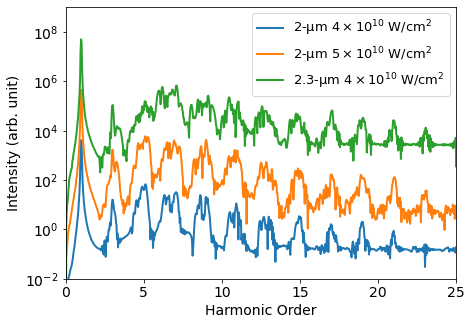

In [169]:
fig = plt.figure()
fig.set_size_inches(7, 5)

plt.semilogy(tddft_data_2_low['w_norm'], 
             np.abs(tddft_data_2_low['F_gen_f']),
            label=u'2-\u03BCm' + r' $4\times10^{10}$ W/cm${}^2$',
            linewidth=2.0)

plt.semilogy(tddft_data_2_high['w_norm'], 
             np.abs(tddft_data_2_high['F_gen_f'])*100, 
            label=u'2-\u03BCm' + r' $5\times10^{10}$ W/cm${}^2$',
            linewidth=2.0)

plt.semilogy(tddft_data_2p3_low['w_norm'], 
             np.abs(tddft_data_2p3_low['F_gen_f'])*1e4,
            label=u'2.3-\u03BCm' + r' $4\times10^{10}$ W/cm${}^2$',
            linewidth=2.0)

plt.xlim(0, 25)
plt.xlabel('Harmonic Order', fontsize=14)
plt.ylabel('Intensity (arb. unit)', fontsize=14)
plt.ylim(1e-2, 1e9)
plt.legend(fontsize=13)
plt.tick_params(labelsize=14)

## Time-Domain Fields

Comparison of the nonlinear fields in the time-domain.  These HH fields are those from the chosen spectral region above.  

For comparison, they are shown against both the vector potential and electric field of the driving waveform.

### 2-um -- 4e10 W/cm2

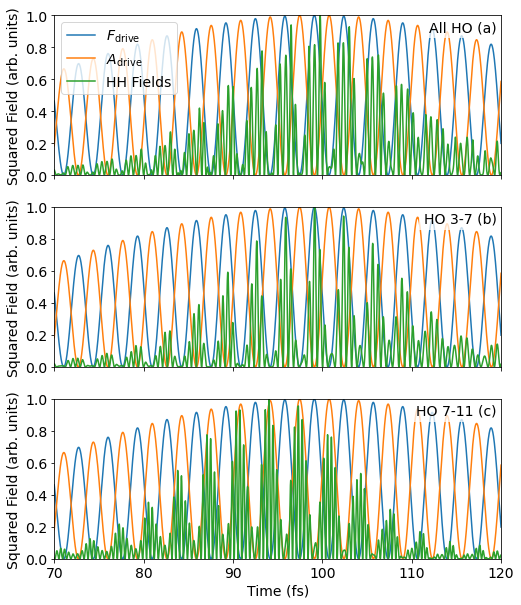

In [5]:
fig = plt.figure()
fig.set_size_inches(8, 10)

# -- All Harmonics -- 
ax1 = fig.add_subplot(3, 1, 1)

ax1.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax1.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_low['t']*1e15/pca.tcon, (tddft_data_2_low['F_gen']/tddft_data_2_low['F_gen'].max())**2)

harm_start = 2
harm_end = 40
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_low['w_norm'], 
                                                    tddft_data_2_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax1.plot(t_2_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'All HO (a)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax1.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.legend(fontsize=14, loc='upper left')
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.tick_params('x', labelbottom=False)
plt.xlim(70, 120)
plt.ylim(0, 1)

# -- HO 3-7 -- 
ax2 = fig.add_subplot(3, 1, 2)

ax2.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax2.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_low['t']*1e15/pca.tcon, (tddft_data_2_low['F_gen']/tddft_data_2_low['F_gen'].max())**2)

harm_start = 2
harm_end = 8
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_low['w_norm'], 
                                                    tddft_data_2_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax2.plot(t_2_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 3-7 (b)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax2.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(70, 120)
plt.ylim(0, 1)
plt.tick_params('x', labelbottom=False)

# -- HO 7-11 -- 
ax3 = fig.add_subplot(3, 1, 3)

ax3.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax3.plot(tddft_data_2_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_low['t']*1e15/pca.tcon, (tddft_data_2_low['F_gen']/tddft_data_2_low['F_gen'].max())**2)

harm_start = 6
harm_end = 12
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_low['w_norm'], 
                                                    tddft_data_2_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax3.plot(t_2_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 7-11 (c)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax3.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.xlabel('Time (fs)', fontsize=14)
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(70, 120)
plt.ylim(0, 1);

### 2-um -- 5e10 W/cm2

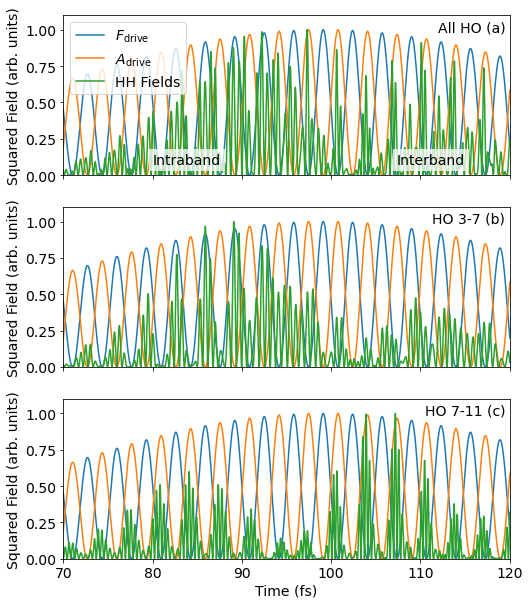

In [6]:
fig = plt.figure()
fig.set_size_inches(8, 10)

# -- All Harmonics -- 
ax1 = fig.add_subplot(3, 1, 1)

ax1.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax1.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_high['t']*1e15/pca.tcon, (tddft_data_2_high['F_gen']/tddft_data_2_high['F_gen'].max())**2)

harm_start = 2
harm_end = 40
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_high['w_norm'], 
                                                    tddft_data_2_high['F_gen_f'], 
                                                    harm_start, harm_end)
ax1.plot(t_2_high_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'All HO (a)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax1.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.text(0.20, 0.05, 'Intraband', 
         horizontalalignment='left',
         verticalalignment='bottom', 
         transform=ax1.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.text(0.90, 0.05, 'Interband', 
         horizontalalignment='right',
         verticalalignment='bottom', 
         transform=ax1.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.legend(fontsize=14, loc='upper left')
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.tick_params('x', labelbottom=False)
plt.xlim(70, 120)
plt.ylim(0, 1.1)

# -- HO 3-7 -- 
ax2 = fig.add_subplot(3, 1, 2)

ax2.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax2.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_high['t']*1e15/pca.tcon, (tddft_data_2_high['F_gen']/tddft_data_2_high['F_gen'].max())**2)

harm_start = 2
harm_end = 8
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_high['w_norm'], 
                                                    tddft_data_2_high['F_gen_f'], 
                                                    harm_start, harm_end)
ax2.plot(t_2_high_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 3-7 (b)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax2.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(70, 120)
plt.ylim(0, 1.1)
plt.tick_params('x', labelbottom=False)

# -- HO 7-11 -- 
ax3 = fig.add_subplot(3, 1, 3)

ax3.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax3.plot(tddft_data_2_high['t_drive']*1e15/pca.tcon, 
         tddft_data_2_high['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2_high['t']*1e15/pca.tcon, (tddft_data_2_high['F_gen']/tddft_data_2_high['F_gen'].max())**2)

harm_start = 6
harm_end = 12
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_high['w_norm'], 
                                                    tddft_data_2_high['F_gen_f'], 
                                                    harm_start, harm_end)
ax3.plot(t_2_high_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 7-11 (c)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax3.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.xlabel('Time (fs)', fontsize=14)
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(70, 120)
plt.ylim(0, 1.1);

### 2.3-um -- 4e10 W/cm2

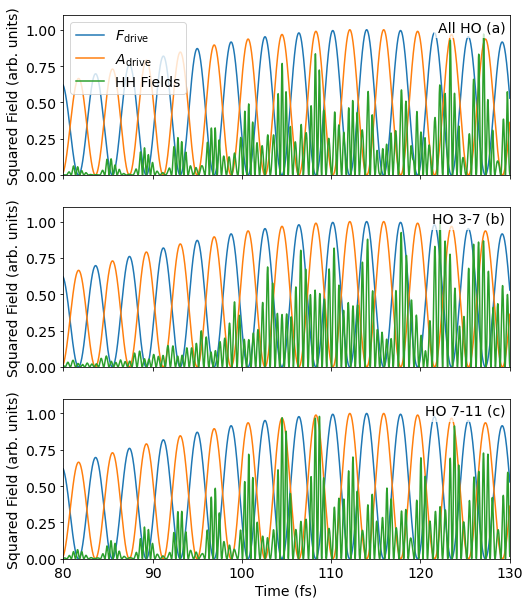

In [7]:
fig = plt.figure()
fig.set_size_inches(8, 10)

# -- All Harmonics -- 
ax1 = fig.add_subplot(3, 1, 1)

ax1.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax1.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2p3_low['t']*1e15/pca.tcon, (tddft_data_2p3_low['F_gen']/tddft_data_2p3_low['F_gen'].max())**2)

harm_start = 2
harm_end = 40
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2p3_low['w_norm'], 
                                                    tddft_data_2p3_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax1.plot(t_2p3_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'All HO (a)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax1.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.legend(fontsize=14, loc='upper left')
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.tick_params('x', labelbottom=False)
plt.xlim(80, 130)
plt.ylim(0, 1.1)

# -- HO 3-7 -- 
ax2 = fig.add_subplot(3, 1, 2)

ax2.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax2.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2p3_low['t']*1e15/pca.tcon, (tddft_data_2p3_low['F_gen']/tddft_data_2p3_low['F_gen'].max())**2)

harm_start = 2
harm_end = 8
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2p3_low['w_norm'], 
                                                    tddft_data_2p3_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax2.plot(t_2p3_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 3-7 (b)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax2.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(80, 130)
plt.ylim(0, 1.1)
plt.tick_params('x', labelbottom=False)

# -- HO 7-11 -- 
ax3 = fig.add_subplot(3, 1, 3)

ax3.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax3.plot(tddft_data_2p3_low['t_drive']*1e15/pca.tcon, 
         tddft_data_2p3_low['A_drive']**2, 
         label=r'$A_\mathrm{drive}$')
# ax1.plot(tddft_data_2p3_low['t']*1e15/pca.tcon, (tddft_data_2p3_low['F_gen']/tddft_data_2p3_low['F_gen'].max())**2)

harm_start = 6
harm_end = 12
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2p3_low['w_norm'], 
                                                    tddft_data_2p3_low['F_gen_f'], 
                                                    harm_start, harm_end)
ax3.plot(t_2p3_low_fs, (F_gen_region/np.abs(F_gen_region).max())**2, label='HH Fields')

#Labeling and look
plt.text(0.99, 0.925, 'HO 7-11 (c)', 
         horizontalalignment='right',
         verticalalignment='center', 
         transform=ax3.transAxes,
         fontsize=14,
         bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
plt.xlabel('Time (fs)', fontsize=14)
plt.ylabel('Squared Field (arb. units)', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(80, 130)
plt.ylim(0, 1.1);

## Sampling Simulations and Analysis

The purpose of the following is to compare the actual fields to the result one would obtain via sampling.

Currently the sampled response assumes a flat bandwidth response from the antenna.  We know this is not true, but can be further corrected for in a similar way to the spectral correction below.  

First we need to calculate the cross correlation of the current response of the sampler.

In [170]:
# -- Pulse Information -- 

harm_start = 2
harm_end = 40
F_gen_region, F_gen_region_f = load.cutSpectralRegion(tddft_data_2_high['w_norm'], 
                                                    tddft_data_2_high['F_gen_f'], 
                                                    harm_start, harm_end)

w0 = 0.023 #Angular frequency of drive (atomic units)

t_fs = t_2_high_fs
t = t_2_high

#Driving pulse and parameters
dt_fs = t_fs[1] - t_fs[0]
t_drive = np.arange(-200, 200, dt_fs) #time axis for driver
wc_drive = w0*pca.tcon*1e-15 #Central frequency (rad/fs)
fwhm_drive = 15 #FWHM in femtoseconds of the driver pulse
phi_ce_drive = np.pi #Carrier envelope phase (rad)

# -- Sampling Parameters -- 
tau_range = np.arange(-60, 150, 0.1) #Delay range (fs)
J = np.zeros(tau_range.shape) # Vector for output current density

F_max = 7 #Maximum driver field (V/nm)
phi = 5.1 #Work function of electron emitter (eV)

sample_factor = 1e-4 #Field ratio between HHG and driver
F_0 = 0.0; #DC bias field value (V/nm)

# -- End Settings -- 

# -- Calcualations and Preparation for Cross-Correlation --

#Zero-pad the harmonic pulse to be the same length as the driving pulse
#for the cross-correlation calculation below.
del_length = t_drive.size - F_gen_region.size
del_length_left = int(np.ceil(del_length/2.0))
del_length_right = int(np.floor(del_length/2.0))



F_gen_region_pad = np.zeros(t_drive.shape)
F_gen_region_pad = np.pad(F_gen_region/F_gen_region.max(),
                          (del_length_left, del_length_right))
    
# -- Cross-Correlation Loop --
J_corr = np.zeros(tau_range.shape)

k = 0
for tau in tau_range:
    
    #Create the drive pulse
    drive_pulse = pulses.cos2pulse(t_drive - tau,
                                   fwhm_drive,
                                   wc_drive,
                                   phi_ce_drive)
 

    J_corr[k] = np.trapz(t_drive,
                   FN.J_FN_SI(F_0 + F_max*drive_pulse['E']  +
                              sample_factor*F_gen_region_pad,
                              phi))
    
    k = k + 1

#Remove the background current to extract
#only the cross-correlation current of interest. 
J_corr = J_corr - J_corr[0]

Next we plot the raw small-signal current modulation against the actual signal.

Text(0, 0.5, 'Harmonic Field/Sampler Output (arb. units)')

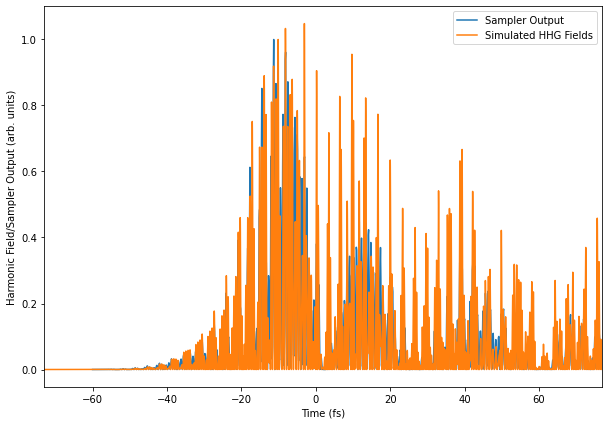

In [171]:
# -- Compare the correlation current with the harmonic signal of interest:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = []
t_cycle_centered = 2
t_range = 150

t_fs_centered = t_fs - (t_fs[-1] + t_fs[0])/2.0

ax.append(fig.add_subplot(1, 1, 1))
ax[0].plot(tau_range, (J_corr/J_corr.max())**2, label='Sampler Output')
ax[0].plot(t_fs_centered, (F_gen_region/F_gen_region.max())**2, label='Simulated HHG Fields')
ax[0].set_xlim(t_cycle_centered - t_range/2.0, t_cycle_centered + t_range/2.0)
ax[0].legend()
ax[0].set_xlabel('Time (fs)')
ax[0].set_ylabel('Harmonic Field/Sampler Output (arb. units)')

Next we plot the sampler bandwith response...

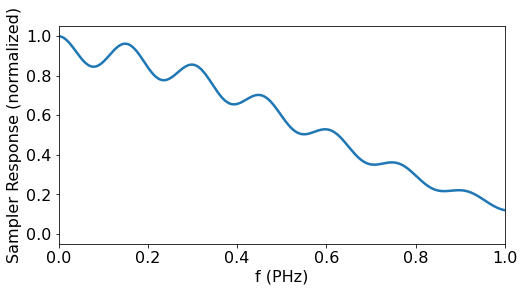

In [172]:
# -- Get frequency representation of each pulse --
#  - Note the suffix _f denotes fourier-transformed version of the variable.

#Cross-correlation current:
dt_J_corr = tau_range[1] - tau_range[0]
w_J_corr = np.fft.fftfreq(tau_range.size, d=dt_J_corr)*2*np.pi
w_J_corr = np.fft.fftshift(w_J_corr)
J_corr_f = np.fft.fft(J_corr)
J_corr_f = np.fft.fftshift(J_corr_f)

#Generated field data
# -- unfortunately above we took single-sided spectra, so to make it match
# -- up here we need the double-sided FT data...
w_simulation = np.fft.fftfreq(t.size, d=dt_fs)*2*np.pi
w_simulation = np.fft.fftshift(w_simulation)
simulation_f = np.fft.fft(F_gen_region)
simulation_f = np.fft.fftshift(simulation_f)

#Driving pulse
dt_drive = t_drive[1] - t_drive[0]
drive_pulse = pulses.cos2pulse(t_drive,
                               fwhm_drive,
                               wc_drive,
                               phi_ce_drive)
w_drive = np.fft.fftfreq(t_drive.size, d=dt_drive)*2*np.pi
w_drive = np.fft.fftshift(w_drive)
dJ_dF_drive = FN.dJ_dF_FN_SI(F_max*drive_pulse['E'] + F_0, phi)
J_drive = FN.J_FN_SI(F_max*drive_pulse['E'] + F_0, phi)
H_sampler = np.fft.fft(np.fft.fftshift(dJ_dF_drive)) #Transfer function of the sampler
H_sampler = np.fft.fftshift(H_sampler)
H_sampler = H_sampler/np.max(np.abs(H_sampler))

# -- Plot the sampler transfer-function: H_sampler
fig = plt.figure()
fig.set_size_inches(8, 4)

plt.plot(w_drive/np.pi/2, np.abs(H_sampler), linewidth=2.5)
plt.xlim(0, 1)
plt.xlabel('f (PHz)', fontsize=16)
plt.ylabel('Sampler Response (normalized)', fontsize=16)
plt.tick_params(labelsize=16)

fig.savefig('sampler-bandwidth-response.pdf', bbox_inches='tight')

... and time-domain response.

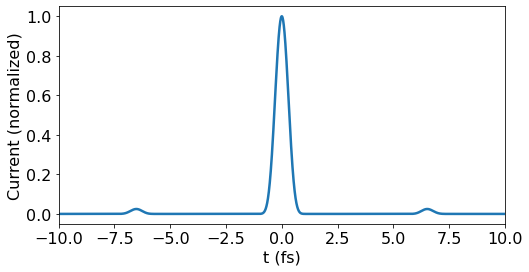

In [173]:
fig = plt.figure()
fig.set_size_inches(8, 4)

plt.plot(t_drive, J_drive/J_drive.max(), linewidth=2.5)
plt.xlabel('t (fs)', fontsize=16)
plt.ylabel('Current (normalized)', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-10, 10)
fig.savefig('sampler-current-response.pdf', bbox_inches='tight')

### Correct the sampled pulse in frequency-domain

Finally, we correct the response by removing the amplitude envelope of the finite bandwidth response of the sampler due to the emission response.  

Again, if the antenna itself has a finite bandwidth, this could also be incorporated/accounted for here in a similar way. However, we currently assume the antenna bandwidth is infinite.

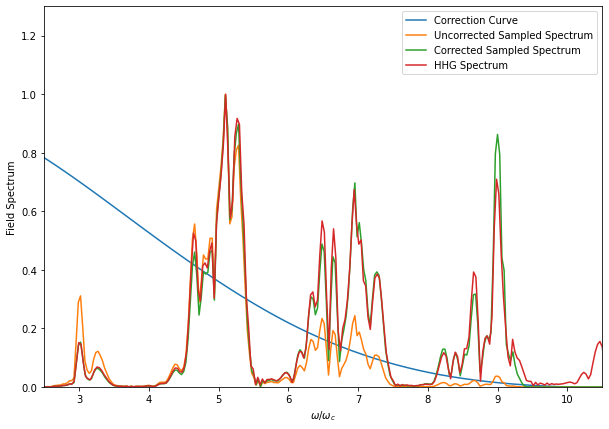

In [174]:
# -- Get the peaks fo the first +/-N harmonics:
N = 10 #Number of harmonics to correct
H_sampler_n = np.zeros(2*N + 1) + 0j #Sampler value at each harmonic (for envelope determination)
harm_corr_start = 0
harm_corr_end = 9.5

#Find H_sampler at each harmnic value n in [-N, N].
k = 0
for n in range(-N, N+1):

  index = np.where(w_drive/wc_drive <= n)[0][-1]
  H_sampler_n[k] = H_sampler[index]
  k = k + 1

#Get the correction frequency response interpolated on the same frequency
#axis as harmonic_pulse_simulation...
f_correction = interpolate.interp1d(np.arange(-N, N+1),
                                    np.abs(H_sampler_n),
                                    kind='cubic') #interp function
w_correction_range = np.where((w_J_corr/wc_drive < N)&(w_J_corr/wc_drive > -N))
  #index range where these harmonics are located
w_correction_norm = w_J_corr[w_correction_range]/wc_drive #Get relevant frequency points
correction = f_correction(w_correction_norm) #Now determine the correction curve
correction = correction/correction.max()


F_sampled, F_sampled_f = load.cutSpectralRegion(w_J_corr/wc_drive, 
                                                    J_corr_f/(np.abs(J_corr_f)).max(), 
                                                    harm_corr_start, harm_corr_end)

J_corr_f_corrected = J_corr_f
J_corr_f_corrected[w_correction_range] = (J_corr_f[w_correction_range]/correction)/(np.abs(J_corr_f[w_correction_range]/correction)).max()
F_sampled_corrected, F_sampled_corrected_f = load.cutSpectralRegion(np.fft.fftshift(w_J_corr/wc_drive), 
                                                    np.fft.fftshift(J_corr_f_corrected), 
                                                    harm_corr_start, harm_corr_end)

#-- Plot the original and corrected spectra, along with the correction factor curve
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = []
k = 0    
ax.append(fig.add_subplot(1, 1, 1))

ax[k].plot(w_correction_norm, np.abs(correction), label='Correction Curve')

ax[k].plot(w_J_corr/wc_drive, np.abs(F_sampled_f),
     label='Uncorrected Sampled Spectrum')

ax[k].plot(w_J_corr/wc_drive, np.fft.fftshift(np.abs(F_sampled_corrected_f)), 
           label='Corrected Sampled Spectrum')

ax[k].plot(w_simulation/wc_drive, np.abs(simulation_f)/(np.abs(simulation_f)).max(),
     label='HHG Spectrum')

ax[k].set_xlim(2.5, 10.5)
ax[k].set_ylim(0, 1.3)
ax[k].legend()
ax[k].set_xlabel('$\omega/\omega_c$')
ax[k].set_ylabel('Field Spectrum');

Text(0, 0.5, 'Harmonic Field/Sampler Output (arb. units)')

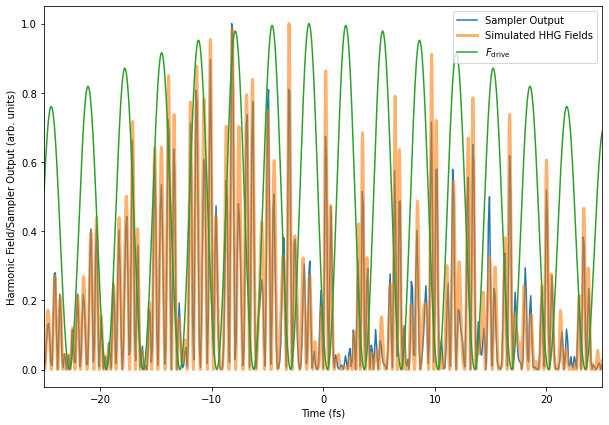

In [175]:
J_corr_f_corrected = J_corr_f + 0j
J_corr_f_corrected[w_correction_range] = J_corr_f[w_correction_range]/correction

J_corr_corrected = np.real(np.fft.ifft(np.fft.fftshift(J_corr_f_corrected)))

# -- Compare the correlation current with the harmonic signal of interest:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax = []
t_cycle_center = 0
t_range = 50

t_fs_center = (t_fs[-1] + t_fs[0])/2.0

ax.append(fig.add_subplot(1, 1, 1))
# ax[0].plot(tau_range, (J_corr_corrected/np.abs(J_corr_corrected).max())**2, 
#            label='Sampler Output')
ax[0].plot(tau_range, (F_sampled_corrected/np.abs(F_sampled_corrected).max())**2, 
           label='Sampler Output')
ax[0].plot(t_fs_centered, (F_gen_region/np.abs(F_gen_region).max())**2, 
           label='Simulated HHG Fields',
           linewidth=3.0, alpha=0.6)
ax[0].plot(tddft_data_2_high['t_drive']*1e15/pca.tcon - t_fs_center, 
         tddft_data_2_high['F_drive']**2, 
         label=r'$F_\mathrm{drive}$')
ax[0].set_xlim(t_cycle_center - t_range/2.0, t_cycle_center + t_range/2.0)
ax[0].legend()
ax[0].set_xlabel('Time (fs)')
ax[0].set_ylabel('Harmonic Field/Sampler Output (arb. units)')

### Gabor Transform -- High Spectral + High Temporal Resolution

In [247]:
T = 2*np.pi/w0 #in atomic units
dt = (tau_range[1] - tau_range[0])*1e-15*pca.tcon
nperseg_spec = np.ceil(T/dt) + 1
noverlap_spec = np.floor(nperseg_spec/2.0)

#Calculate spectrogram
#f_spec, t_spec, spectrogram = stft(tddft_data['F_gen'], fs = pca.tcon/dt/1e15, 
#                           nperseg=3*nperseg_spec, window=('gaussian', nperseg_spec*3))

f_spec, t_spec, spectrogram = stft(F_sampled_corrected, fs = pca.tcon/dt/1e15, 
                                nperseg=nperseg_spec*5,
                                noverlap=nperseg_spec*4.9,
                                window=('gaussian', nperseg_spec*0.35))


f_harm = w0*pca.tcon/2/np.pi/1e15 #harmonic frequency
f_norm = f_spec/f_harm #Normalized by harmonic order
c_norm = np.max(np.abs(spectrogram[np.where(f_norm >= 5), :]))
spectrogram = spectrogram/c_norm


#Store data for later plotting after this analysis:
spectrogram_sampled = spectrogram
f_norm_sampled = f_norm
t_spec_sampled = t_spec + tau_range[0]

In [251]:
T = 2*np.pi/w0 #in atomic units
dt = t[1] - t[0]
nperseg_spec = np.ceil(T/dt) + 1
noverlap_spec = np.floor(nperseg_spec/2.0)

#Calculate spectrogram
#f_spec, t_spec, spectrogram = stft(tddft_data['F_gen'], fs = pca.tcon/dt/1e15, 
#                           nperseg=3*nperseg_spec, window=('gaussian', nperseg_spec*3))

f_spec, t_spec, spectrogram = stft(tddft_data_2_high['F_gen'], fs = pca.tcon/dt/1e15, 
                                nperseg=nperseg_spec*5,
                                noverlap=nperseg_spec*4.9,
                                window=('gaussian', nperseg_spec*0.35))

spectrogram = spectrogram/np.max(np.max(np.abs(spectrogram)))



f_harm = w0*pca.tcon/2/np.pi/1e15 #harmonic frequency
f_norm = f_spec/f_harm #Normalized by harmonic order
c_norm = np.max(np.abs(spectrogram[np.where(f_norm >= 5), :]))
spectrogram = spectrogram/c_norm

#Store data for later plotting after this analysis:
spectrogram_simulated = spectrogram
f_norm_simulated = f_norm
t_spec_simulated = t_spec - t_fs_center - 

print(t_spec_sampled[0] - 2.5*T*1e15/pca.tcon)
print(t_spec_simulated[0])
print(tau_range[0])

-76.51988963050349
-100.38249010779424
-60.0


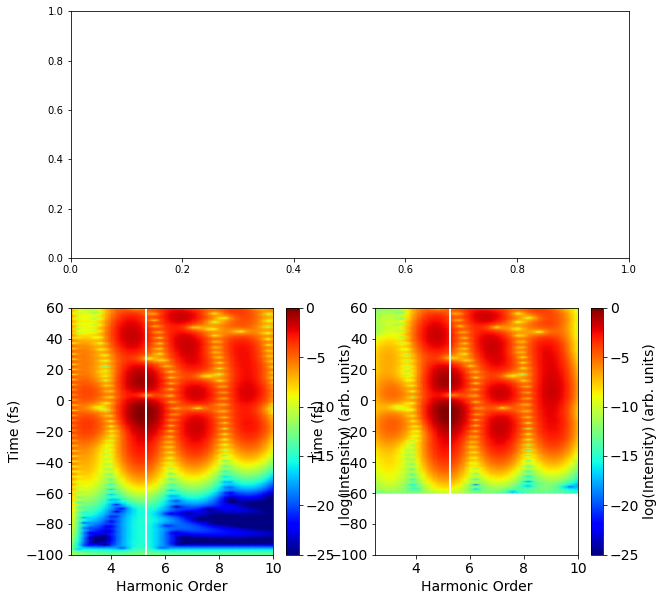

In [249]:
fig = plt.figure()
fig.set_size_inches(10, 10)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])

ax2 = fig.add_subplot(gs[1, 0])

plt.pcolormesh(f_norm_simulated, t_spec_simulated, 
               np.log(np.abs(spectrogram_simulated)**2).transpose(), 
               shading='gouraud', cmap='jet')


#plt.ylim(40 - 2*6.6, 40 + 2*6.6)

plt.xlabel('Harmonic Order', fontsize=14)
plt.ylabel('Time (fs)', fontsize=14)
cbar = plt.colorbar()
#plt.clim(-20, -5)
plt.clim(-25, 0)
plt.ylim(-100, 60)
plt.xlim(2.5, 10)

plt.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('log(Intensity) (arb. units)', fontsize=14)

photon_energy = f_harm*1e15*2*np.pi*pcSI.hbar/pcSI.evcon #Find photon energy of driver in eV
plt.axvline(BG/photon_energy, linewidth=2, color='white');

ax3 = fig.add_subplot(gs[1, 1])

plt.pcolormesh(f_norm_sampled, t_spec_sampled, 
               np.log(np.abs(spectrogram_sampled)**2).transpose(), 
               shading='gouraud', cmap='jet')


#plt.ylim(40 - 2*6.6, 40 + 2*6.6)

plt.xlabel('Harmonic Order', fontsize=14)
plt.ylabel('Time (fs)', fontsize=14)
cbar = plt.colorbar()
#plt.clim(-20, -5)
plt.clim(-25, 0)
plt.ylim(-100, 60)
plt.xlim(2.5, 10)

plt.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('log(Intensity) (arb. units)', fontsize=14)

photon_energy = f_harm*1e15*2*np.pi*pcSI.hbar/pcSI.evcon #Find photon energy of driver in eV
plt.axvline(BG/photon_energy, linewidth=2, color='white');